In [1]:
import random
import numpy as np
import pandas as pd
from numpy.random import randn, randint
from scipy.linalg import norm
import matplotlib.pyplot as plt

In [2]:
# generate random data matrix
random.seed(0)
n,d = 6,4
X = randn(n,d)

# optional: give it linearly dependent columns
# X[:,3] = X[:,2]

In [3]:
# form data from noisy linear model
wtrue = randn(d)
y = X.dot(wtrue) + .1*randn(n)

In [4]:
# look at least squares objective as a function of w
def f(w):
    return norm(y - X.dot(w))**2

def gradf(w):
    return 2*X.T @ (X @ w) - 2*X.T @ y

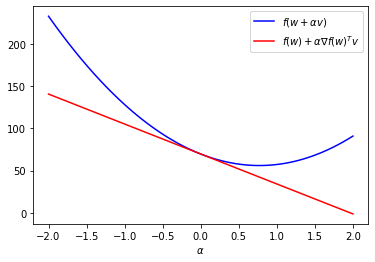

In [5]:
# gradient at w approximates f(w) near w
w = randn(d)
v = randn(d)
alphas = np.linspace(-2,2,100)
plt.plot(alphas, [f(w + alpha*v) for alpha in alphas], color='b', 
     label=r"$f(w + \alpha v)$")
plt.plot(alphas, [f(w) + alpha*gradf(w).dot(v) for alpha in alphas], color='r', 
      label=r"$f(w) + \alpha \nabla f(w)^T v$")
plt.xlabel(r"$\alpha$")
plt.legend()

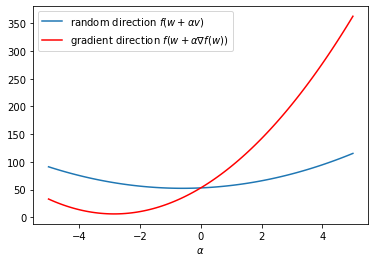

In [6]:
# function decreases fastest in the -∇f(w) direction
w = randn(d)
v = randn(d)
v_normalized = v/norm(v)
g = gradf(w)
g_normalized = g/norm(g)
alphas = np.linspace(-5,5,100)
plt.plot(alphas, [f(w + alpha*v_normalized) for alpha in alphas], 
     label = r"random direction $f(w + \alpha v)$")
plt.plot(alphas, [f(w + alpha*g_normalized) for alpha in alphas], color='r', 
         label= r"gradient direction $f(w + \alpha \nabla f(w))$")
plt.xlabel(r"$\alpha$")
plt.legend()
# notice: compared to blue line, red line always goes down faster to the left and up faster to the right

# gradient descent

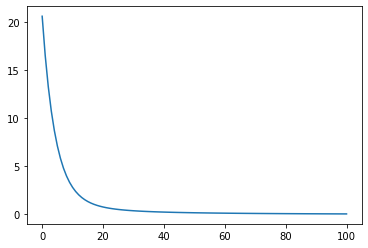

In [7]:
"""This function implements gradient descent for the function f with gradient ∇f"""
def gradient_descent(f, gradf,
                     alpha = .01,      # small constant step size - try other values!
                     w = np.zeros(d),     # start at a random w
                     maxiters = 100    # maximum number of iterations 
                     ):
    fks = []  # a list to record all the values f(w) we see
    fks.append(f(w)) # record the initial value

    # start descending!
    for k in range(maxiters):
        w = w - alpha*gradf(w)       # take a gradient step
        fks.append(f(w))             # record its value
    return w, fks

w, fks = gradient_descent(f, gradf, alpha = .01)

plt.plot(fks, label="sum of square errors")
#plt.semilogy(fks, label="sum of square errors")
#plt.loglog(fks, label="sum of square errors")

# Armijo rule

Text(0.5, 0, '$\\alpha$')

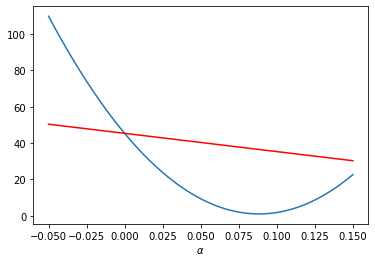

In [8]:
# function decreases fastest in the -∇f(w) direction
random.seed(1)

w = randn(d)
g = gradf(w)
c = .1
alphas = .05*np.linspace(-1,3,100)
plt.plot(alphas, [f(w - alpha*g) for alpha in alphas], 
     label = r"$f(w - \alpha \nabla f(w))$")
plt.plot(alphas, [f(w) - c*alpha*norm(g)**2 for alpha in alphas],color='r', 
         label=r"$f(w) - c\alpha \|\nabla f(w)\|^2$")
plt.xlabel(r"$\alpha$")


# Gradient descent with linesearch

Poll: gradient descent with linesearch will converge in ____ iterations than without
* A. more 
* B. fewer

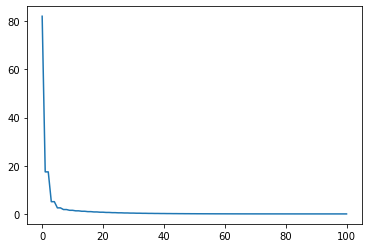

In [9]:
"""This function implements gradient descent with linesearch for the function f with gradient ∇f"""
def gradient_descent_linesearch(f, gradf,
                                alpha = 1,      # initial step size - try other values!
                                w = randn(d),     # start at a random w
                                maxiters = 100,   # maximum number of iterations 
                                c = .01            # Armijo sufficient decrease
                                ):

    fks = []  # a list to record all the values f(w) we see
    fw = f(w)
    fks.append(fw) # record the initial value
    g = gradf(w)
    alpha0 = alpha
    
    # start descending!
    for k in range(maxiters):
        w_new = w - alpha*g      # take a gradient step
        fw_new = f(w_new)
        while fw_new > fw - c*alpha*norm(g)**2:
            alpha /= 2
            w_new = w - alpha*g      # take a gradient step
            fw_new = f(w_new)
        w, fw, g = w_new, fw_new, gradf(w)
        alpha = alpha0
        fks.append(fw)
    return w, fks

w, fks = gradient_descent_linesearch(f, gradf, alpha = 1, c = .01)

plt.plot(fks, label="sum of square errors")
# plt.semilogy(fks, label="sum of square errors")
# plt.loglog(fks, label="sum of square errors")

# Stochastic gradient

In [10]:
"""
This function implements the stochastic gradient method
for the function sum_i f(x_i, y_i; w), 
where f has gradient wrt w gradf(X,y,w)
"""
def sgd(gradf, 
        data,                # an iterable [(X_1, y_1), ...]
        w,                   # initial guess for w
        alpha = .01,         # small constant step size - try other values!
        maxiters = 100,      # maximum number of iterations 
        f_validation = None, # evaluate w on a validation set
        validation_freq = 1  # compute value on validation set every validation_freq iterations
        ):
    fks = []  # a list to record the validation values f(w) we see

    # start descending!
    k = 0
    for X,y in data:
        
        # stopping condition
        if k > maxiters:
            break
        
        # logging: record value on validation set
        if (f_validation is not None) & k%validation_freq==0:
            fks.append(f_validation(w))

        # iterate
        w = w - alpha*gradf(X,y,w)       # take a gradient step
        k += 1                           # increment k
    return w, fks

## Apply SGD to a random synthetic dataset

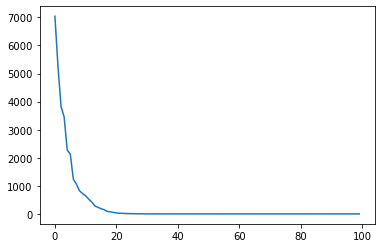

In [11]:
n,d = 500,20
X = randn(n,d)
wtrue = randn(d)
y = X.dot(wtrue) + .1*randn(n)

def random_chunk(X,y,size):
    n = len(y)
    s = randint(n, size=size)
    return X[s,:], y[s]

"""f_validation evaluates the objective on the whole dataset"""
def f_validation(w):
    return norm(y - X.dot(w))**2

"""gradf evaluates the gradient on the given chunk"""
def gradf(X,y,w):
    return 2*X.T @ (X @ w) - 2*X.T @ y

maxiters = 100
data = [random_chunk(X,y,10) for i in range(maxiters)]

w, fks = sgd(gradf, data, w = np.zeros(d), f_validation=f_validation, 
             validation_freq=1, maxiters=maxiters)

plt.plot(fks)

## apply SGD to a large csv
Here we read sequential (not random) chunks of the file to compute each gradient step

In [12]:
# generate a (random) large csv 
file_name = "random.csv"
n,d = 10000, 10
X = randn(n,d)
y = X@randn(d,1)
Z = np.hstack([y,X])
df = pd.DataFrame(Z)
df.to_csv(file_name)

In [13]:
for chunk in pd.read_csv(file_name, chunksize=3):
    print(chunk)
    break

   Unnamed: 0         0         1         2         3         4         5  \
0           0 -1.928541  0.221520 -1.719116  0.727159  0.315714  0.987847   
1           1  2.059519 -2.014124 -0.350726 -0.687778  1.900227 -0.207016   
2           2 -0.861123 -1.189356 -0.366343  0.359684  2.585325 -0.235279   

          6         7         8         9        10  
0 -1.216366 -0.549397  0.562146 -0.002836 -0.528120  
1  1.734258  2.161093  0.905353 -1.264249  0.853023  
2  2.515936 -2.407380 -0.776047  0.355439 -0.430640  


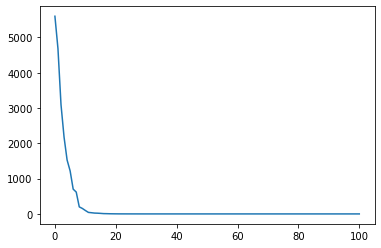

In [14]:
data_validation = pd.read_csv(file_name, nrows=1000)
X_validation, y_validation = data_validation.iloc[:,2:], data_validation.iloc[:,1]

"""f_validation evaluates the objective on the whole dataset"""
def f_validation(w):
    return norm(y_validation - X_validation.dot(w))**2

"""gradf evaluates the gradient on the given chunk"""
def gradf(X,y,w):
    return 2*X.T @ (X @ w) - 2*X.T @ y

maxiters = 100
data = [(chunk.iloc[:,2:], chunk.iloc[:,1]) for chunk in pd.read_csv(file_name, chunksize=10)]

w, fks = sgd(gradf, data, w=np.zeros(d), 
             f_validation=f_validation, 
             validation_freq=1, maxiters=maxiters)

plt.plot(fks)

# preprocess some large datasets

In [15]:
# import tensorflow.compat.v2 as tf
# import tensorflow_datasets as tfds

# # Construct a tf.data.Dataset
# ds = tfds.load('higgs', split='train', shuffle_files=True)

# # Build your input pipeline
# ds = ds.shuffle(1024).batch(32).prefetch(tf.data.experimental.AUTOTUNE)

In [16]:
# for example in ds.take(1):
#   print(example)

In [17]:
# dr['df'].to_csv('yaleemmlc.csv')